# Task Inference on The Differential Level

## Setup
- We assume that there exists an unknown Lie group G that induces the reward and transition functions of the different tasks
- We have samples from different tasks
- We assume that the level sets of the different tasks are all connected curves (a foliation?)
- We know that the reward and transition function of each task have a Kernel. For now, assume that only reward functions change. Thereby, the different tasks have reward-function Kernels D^1, ..., D^N_tasks
- Thereby, there should exists a Lie group tilde(G) acting on S and A that aligns the different Kernels. This means that for all p in M, there should exist a left-action l_tilde(G) in tilde(G) such that the Kernel of the new task D^2(l_tilde(G)(p)) = D^(p)
    - If such a Lie group tilde(G) exists, we have successfully translated the geometry in m into a geometry in S times A
    - How can we learn such a Lie group?
        - a

## Hard-Code Kernels of Each Task

In [1]:
import warnings
from typing import Tuple

from constants import DTYPE
import torch as th
RANDOM_SEED=42
th.manual_seed(RANDOM_SEED)

def sample_kernel_samples_from_task(task_goal: th.tensor,
                                        p_batch: th.tensor)->th.tensor:
    """Returns kernel samples at batched points p from a task."""

    _generator=th.tensor([[0, -1], [1,0]], dtype=DTYPE, requires_grad=False).unsqueeze(0)
    projected_state = (p_batch-task_goal).unsqueeze(-1)
    return th.matmul(_generator, projected_state).squeeze(-1)

N_SAMPLES=250
STATE_DIM=2
TASK_GOALS = []
for k in range(8):
    angle = th.tensor(2 * th.pi * k / 8, dtype=DTYPE)
    TASK_GOALS.append(th.tensor([th.cos(angle), th.sin(angle)], dtype=DTYPE))

## Learn the Push-Forward of each Task

In [2]:
from tqdm import tqdm
def compute_push_forward(F_0:th.tensor,
                         vf_1:callable,
                         vf_2:callable,
                         n_iter:int=20_000,
                         batch_size:int=128,
                         state_dim:int=2
                         )->th.tensor:
    """Computes via gradient-flow a linear push-forward from a vector field vf_1 to another vector field vf_2.
    Args:
    - F_0: torch.tensor of shape (N_states, N_states), initialization of the push-forward
    - vf_1: callable, first vector field, takes in a set of batched points of shape (batch_size, N_states) and returns a set of tangent vectors of shape (batch_size, N_states)
    - vf_2: callable, first vector field, takes in a set of batched points of shape (batch_size, N_states) and returns a set of tangent vectors of shape (batch_size, N_states)
    
    Returns:
    - The linear push-forward if it exists.
    """
    warnings.warn("Only supports linear push-forwards. For non-linear, implement derivative of push-forward.")
    F=th.tensor(F_0.clone(), dtype=DTYPE, requires_grad=True)
    opt_F=th.optim.Adam([F], lr=0.00035)

    pbar = tqdm(range(n_iter), desc="Compute Push-Forward") 
    for idx_step in pbar:
        # Sample points and push-forward points
        ps=th.randn((batch_size, state_dim))
        F_ps=th.einsum("mn,bn->bm",F,ps)

        # Sample tangent vectors and push-forward tangent vectors
        vf_2_F_ps=vf_2(F_ps)
        vf_1_ps=vf_1(ps)
        dF_vf_1_ps=th.einsum("mn,bn->bm",F,vf_1_ps)

        # Compute loss. If F is push-forward, we must have dF_vf_1_ps=vf_2_F_ps
        loss = th.sum(th.norm(dF_vf_1_ps-vf_2_F_ps, dim=1),dim=0)
        
        # Take gradient step
        opt_F.zero_grad()
        loss.backward()
        opt_F.step()
        if idx_step % 100 == 0:
            pbar.set_postfix({'Push-Forward. Loss (optimum=0)': f'{loss:.2f}'})

    return F.round(decimals=3)

In [3]:
# Linear Maps H that map the kernel of task i to the kernel of task 0
F_0_all_tasks=th.tensor(th.randn(size=(STATE_DIM, STATE_DIM)))

# Callables that return a batch of samples from a vector field at a batch of points.
def kernel_fn_of_task(task_goal)->callable:
    """Callable that returns a sample of a vector field at a point."""
    return lambda ps: sample_kernel_samples_from_task(task_goal, p_batch=ps)

vf_tasks = [kernel_fn_of_task(task_goal=task_goal) for task_goal in TASK_GOALS]

# Compute F-Related linear map between Kernels
vf_base_task=vf_tasks[0]
vf_other_tasks=vf_tasks[1:]
lgs_tasks_th = [compute_push_forward(F_0=F_0_all_tasks,
                                     vf_1=vf_base_task,
                                     vf_2=vf_other_task) for vf_other_task in vf_other_tasks]

/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_37186/3330981952.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F_0_all_tasks=th.tensor(th.randn(size=(STATE_DIM, STATE_DIM)))
/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_37186/3049038105.py:18: UserWarning: Only supports linear push-forwards. For non-linear, implement derivative of push-forward.
  warnings.warn("Only supports linear push-forwards. For non-linear, implement derivative of push-forward.")
/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_37186/3049038105.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F=th.tensor(F_0.clone(), dtype=DTYPE, requires_grad=True)
Compute Push-Forward: 1

In [4]:
for idx, lg_task_th in enumerate(lgs_tasks_th):
    print(f"Base Goal Position: {TASK_GOALS[0]}\nTask Goal Position: {TASK_GOALS[idx+1]}\nF-Map: {lg_task_th}\n\n")

Base Goal Position: tensor([1., 0.])
Task Goal Position: tensor([0.7071, 0.7071])
F-Map: tensor([[ 0.7070, -0.7070],
        [ 0.7070,  0.7070]], grad_fn=<RoundBackward1>)


Base Goal Position: tensor([1., 0.])
Task Goal Position: tensor([-4.3711e-08,  1.0000e+00])
F-Map: tensor([[ 0., -1.],
        [ 1., -0.]], grad_fn=<RoundBackward1>)


Base Goal Position: tensor([1., 0.])
Task Goal Position: tensor([-0.7071,  0.7071])
F-Map: tensor([[-0.7070, -0.7070],
        [ 0.7070, -0.7070]], grad_fn=<RoundBackward1>)


Base Goal Position: tensor([1., 0.])
Task Goal Position: tensor([-1.0000e+00, -8.7423e-08])
F-Map: tensor([[-1., -0.],
        [-0., -1.]], grad_fn=<RoundBackward1>)


Base Goal Position: tensor([1., 0.])
Task Goal Position: tensor([-0.7071, -0.7071])
F-Map: tensor([[-0.7070,  0.7070],
        [-0.7070, -0.7070]], grad_fn=<RoundBackward1>)


Base Goal Position: tensor([1., 0.])
Task Goal Position: tensor([ 1.1925e-08, -1.0000e+00])
F-Map: tensor([[ 0.,  1.],
        [-1., -0.]]

## Step 2: Learn Maximal Symmetry

- At this point, we learned left-actions from our unknown group $G$ acting on $S \times A$
    - For each task, we learned one left-action $F_1,...F_{n train}$
    - If these left-actions are indeed linear, we call them $g_1,...,g_{n train}$
- Which Lie group $G$ contains $g_1,...,g_{n train}$?
    - Turns out many, for example $G:=GL(n states)$
- Instead, we can also check whether a Lie group $\hat{G}$ induced by a infinitesimal generator $\hat{W}$ can generate the left-actions $g_1,...,g_{n train}$
    - We know that if $\hat{G}$ is connected, there exists a weight real-valued weight $w$ such that:
        $g_i = exp(w_i W)$
    - Hence, if we apply the matrix-logarithm, we have: $log(g_i)=w_i W$ for some unknown $w_i$
    - This can be easily evaluated by checking whether $log(g_i) \in span(\hat{W}) \forall i=1,...,n train$ 

In [5]:
# Convert left-actions to numpy as torch does not have a matrix logarithm.
# Then compute matrix logarithm of each left-action.
import scipy
import numpy as np
lgs_tasks_np=[lg.detach().numpy() for lg in lgs_tasks_th]
log_lgs_tasks_complex=[scipy.linalg.logm(lg_tasks_np) for lg_tasks_np in lgs_tasks_np]
take_real = lambda num: np.round(np.real(num), 4) if np.all(np.abs(np.imag(num)) < 1e-4) else None
log_lgs_tasks_realb=[take_real(log_lg) for log_lg in log_lgs_tasks_complex]

logm result may be inaccurate, approximate err = 1.4237328349832393e-07
logm result may be inaccurate, approximate err = 1.1337070859873677e-07
logm result may be inaccurate, approximate err = 1.9044607379863199e-07
logm result may be inaccurate, approximate err = 1.9044607379863199e-07
logm result may be inaccurate, approximate err = 1.1337070859873677e-07
logm result may be inaccurate, approximate err = 1.4237328349832393e-07


In [6]:
def project_onto_tensor_subspace(tensors: th.tensor, basis: th.tensor) -> Tuple[th.tensor, th.tensor]:
    """
    Projects 2-tensors onto a d-dimensional subspace of 2-tensors.
    Args:
    - tensors: torch.tensor of shape (b,1,n,n), b two-tensors
    - basis: torch.tensor of shape (1,d,n,n), a d-dimensional vector space of two-tensors, given by its basis.

    Returns: 
    - proj
    """
    b, d, _, _ = basis.shape

    # Compute Gram matrix G: (b, d, d)
    G = th.einsum('bdij,bdij->bd', basis, basis)  # Inner products <B_i, B_j>
    G = G.unsqueeze(-1).expand(-1, -1, d)  # (b,d,d)
    G = G * th.eye(d, device=basis.device).unsqueeze(0) + th.einsum('bdi,bdi->bdi', basis.view(b, d, -1), basis.view(b, d, -1)).transpose(1,2)

    G = th.matmul(basis.view(b, d, -1), basis.view(b, d, -1).transpose(1, 2))  # (b, d, d)
    G_inv = th.linalg.pinv(G)  # (b, d, d)

    # Compute b: (b, d)
    v = tensors.expand(-1, d, -1, -1)  # (b, d, n, n)
    b_proj = th.einsum('bdij,bdij->bd', v, basis)  # (b, d)

    # Compute coefficients alpha: (b, d)
    alpha = th.matmul(G_inv, b_proj.unsqueeze(-1)).squeeze(-1)  # (b, d)

    # Reconstruct projection: sum_i alpha_i * basis_i
    proj = th.sum(alpha.unsqueeze(-1).unsqueeze(-1) * basis, dim=1, keepdim=True)  # (b,1,n,n)
    ortho_comp=tensors-proj
    return proj, ortho_comp

In [7]:
# Log-left actions of the different tasks. Tensor of shape (N_tasks, 1, STATE_DIM, STATE_DIM)
log_lgs_th = [th.tensor(log_lg, dtype=DTYPE).reshape((STATE_DIM, STATE_DIM)) if log_lg is not None else th.zeros(size=(STATE_DIM, STATE_DIM)) for log_lg in log_lgs_tasks_realb]
log_lgs_th = th.stack(log_lgs_th).unsqueeze(1)

In [9]:
DIFF_GENERATOR_ground_truth=th.tensor([[0, -1], [1,0]], dtype=DTYPE, requires_grad=True).unsqueeze(0).unsqueeze(0)
diff_gen_proj, diff_gen_ortho_comp=project_onto_tensor_subspace(tensors=log_lgs_th, basis=DIFF_GENERATOR_ground_truth)

In [10]:
from tqdm import tqdm
def learn_meta_symmetry(W_0:th.tensor,
                         log_left_actions:th.tensor,
                         n_iter:int=20_000,
                         )->th.tensor:
    """Computes the Differential Generator of a Meta Lie Group G from sampled left-actions.
    Args:
    - W_0: torch.tensor of shape (1,d,N_states, N_states), initialization of the differential generator of G
    - left_actions: torch.tensor of shape (N_tasks, 1, N_states, N_states), log of the sampled left-actions from G     
    Returns:
    - XXX
    """

    warnings.warn("Tested only for one-dimensional Meta-Symmetries.")
    assert len(W_0.shape)==4, "Differential Generator must be of shape (1,d,n_states,n_states)"

    W=th.tensor(W_0.clone(), dtype=DTYPE, requires_grad=True)
    opt_F=th.optim.Adam([W], lr=0.00035)

    pbar = tqdm(range(n_iter), desc="Compute Meta-Symmetry")

    for idx_step in pbar:

        # Project log left actions onto the vector space spanned by W.
        # W_perp is the orthogonal complement of each left-action with respect to W
        _, W_perp=project_onto_tensor_subspace(tensors=log_left_actions, basis=W)
        W_perp_flat=W_perp.squeeze(1) #remove the Lie group dimension (always 1). New shape: (N_tasks, N_states, N_states)

        # Compute loss. If G contains all left-actions, the log-left-actions must be inside the span of W.
        # Each orthogonal complement is a tensor of shape (n_state, n_states). Compute the Frobenius norm of each orthogonal complement
        # and mean across all tasks.
        loss = th.mean(th.norm(W_perp_flat, p="fro",dim=(1,2)),dim=0)
        
        # Take gradient step
        opt_F.zero_grad()
        loss.backward()
        opt_F.step()
        if idx_step % 100 == 0:
            pbar.set_postfix({'Meta-Symmetry. Loss (optimum=0)': f'{loss:.2f}'})

    return W.round(decimals=3)

In [14]:
META_GEOMETRY_DIM=1
W_Meta_Sym_0=th.tensor(th.randn(size=(1,META_GEOMETRY_DIM,STATE_DIM, STATE_DIM)))
W_Meta_Sym_star=learn_meta_symmetry(W_0=W_Meta_Sym_0,
                                    log_left_actions=log_lgs_th,
                                    n_iter=25000
                                    )

/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_37186/2080042980.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W_Meta_Sym_0=th.tensor(th.randn(size=(1,META_GEOMETRY_DIM,STATE_DIM, STATE_DIM)))
/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_37186/695153465.py:14: UserWarning: Tested only for one-dimensional Meta-Symmetries.
  warnings.warn("Tested only for one-dimensional Meta-Symmetries.")
/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_37186/695153465.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W=th.tensor(W_0.clone(), dtype=DTYPE, requires_grad=True)
Compute Meta-Symmetry: 100%|██████████| 25000/25000 [00:11<00:00, 2192.84it/s, Meta-Symm

In [15]:
print("Learned Differential Generator of Meta-Symmetry:\n", W_Meta_Sym_star)

Learned Differential Generator of Meta-Symmetry:
 tensor([[[[-0.0000,  0.9940],
          [-0.9940,  0.0000]]]], grad_fn=<RoundBackward1>)


## Step 3: Learn a Meta-Symmetry

- Let $W$ be the differential generator of the Meta-Geometry (acting on $S \times A$)
- Ideally, we want that $G^W$ is also a symmetry of the base-MDP (task 0 for now). Then, we could train in task $0$ and generalize to new tasks to equivariance.
- How can we check whether $G^W$ is a symmetry of the base-MDP?
    - Functional Level: It is a symmetry if each orbit stays within each level set.
    - Differential Level: The Lie-Bracket between $W$ and $D^1$ is closed, e.g. $[V_1,V_2] \in D^1 \forall V_1 \in W, V_2 \in D^1$
    - Which we can (once again) check with the orthogonal complement

In [22]:
CENTER_KERNEL = TASK_GOALS[0] #SO(2) rotation is not a symmetry of this
# CENTER_KERNEL=th.tensor([0,0], dtype=DTYPE) # SO(2) rotation is a symmetry of this

def vector_field_task_1(p: th.tensor)->th.tensor:
    """Returns a kernel sample at a single point p from the base task."""
    _generator=th.tensor([[0, -1], [1,0]], dtype=DTYPE, requires_grad=False)
    projected_state = (p-CENTER_KERNEL)
    return th.matmul(_generator, projected_state)

# def lie_bracket(vf_1: callable,
#                 vf_2: callable,
#                 ps: th.tensor)->th.tensor:
#     """
#     Computes the Lie bracket [vf_1, vf_2]_ps of the vector fields vf_1 and vf_2 at a batch of points ps.
#     Args:
#     - vf_1: callable, a vector field that takes in a batch of points ps and returns a batch of tangent vectors.
#     - vf_2: callable, a vector field that takes in a batch of points ps and returns a batch of tangent vectors.
#     - ps: th.tensor of shape (batch_size, N_states)

#     Returns:
#     - bracket: th.tensor of shape (batch_size, N_states), the Lie Bracket between vf_1 and vf_2, evaluated at ps.
#     """
#     vf_1_batched=th.vmap(vf_1)
#     vf_2_batched=th.vmap(vf_2)

#     def compute_jacobian(f: callable, s: th.tensor)->th.tensor:
#         """Compute a vectorized Jacobian of function f over a batch of states s."""
#         return th.vmap(th.func.jacrev(f))(s)
    
#     # Evaluate vector fields at points.
#     # Tensors of shape (batch_size, N_states, 1)
#     # We add the trailing 1 for batched matrix multiplication.
#     vf_1_ps = vf_1_batched(ps).unsqueeze(-1)
#     vf_2_ps = vf_2_batched(ps).unsqueeze(-1)

#     # Compute Jacobians (vectorized)
#     J_vf_1 = compute_jacobian(vf_1, ps)# .transpose(-1, -2)  # Shape: (batch_size, 2, 2), must be transposed due to jacrev
#     J_vf_2 = compute_jacobian(vf_2, ps)# .transpose(-1, -2)  # Shape: (batch_size, 2, 2), must be transposed due to jacrev

#     # Compute Lie bracket: [X, Y] = J_X @ Y_vals - J_Y @ X_vals
#     bracket = th.bmm(J_vf_1, vf_2_ps) - th.bmm(J_vf_2, vf_1_ps)
#     return bracket.squeeze(-1)

In [24]:
# Callables for the vector fields of the base task and the generator of the symmetry that take in a point p and
# return the vector field evaluated at that point
META_SYMMETRY_LEARNED=th.tensor([[0, -5], [5,0]], dtype=DTYPE)
base_task_vf_1_callable=lambda p : vector_field_task_1(p) 
generator_vf_1_callable=lambda p : th.matmul(META_SYMMETRY_LEARNED, p)
base_task_vf_1_callable_batched=th.vmap(base_task_vf_1_callable)
generator_vf_1_callable_batched=th.vmap(generator_vf_1_callable)

BATCH_SIZE_BRACKET=32
ps=th.randn(size=(BATCH_SIZE_BRACKET,STATE_DIM), dtype=DTYPE)

# # Compute Lie Bracket between kernel vector field of task 1 and generator vector field at different points.
# ps_bracket_kernel_generator=lie_bracket(
#             vf_1=base_task_vf_1_callable,
#             vf_2=generator_vf_1_callable,
#             ps=ps
#             )

# If generator W is a symmetry of $f$, the bracket must again be inside the Kernel.
# E.g., the bracket at p must be inside the span of the Kernel at p.
def project_onto_subspace(vecs: th.tensor, basis: th.tensor) -> Tuple[th.tensor, th.tensor]:
    """Decomposes batch-wise a vector into a projection (projec) and an orthogonal complement (ortho_comp) with respect to a vector space spanned by a basis.
    We have vecs=projec + ortho_comp, projec \in span(basis), ortho_comp \ni span(basis)
    Args:
    vecs: tensor of shape (b,n)
    basis: tensor of shape (b,d,n)

    Returns:
    projec: tensor of shape (b,n), the projection of each vector into the vector space spanned by basis
    ortho_comp: tensor of shape (b,n), the orthogonal complement of each vector relative to the vector space spanned by basis
    """
    basis_t = basis.transpose(1, 2)  #(b,n,d)
    
    # Compute Gram matrix and its pseudo-inverse: (b,d,d)
    G = th.matmul(basis, basis_t)  # (b,d,d)
    G_inv = th.linalg.pinv(G)

    # Compute projection matrix: (b,n,n)
    P = th.matmul(basis_t, th.matmul(G_inv, basis))  # (b,n,n)
    
    # Project vecs: (b,d,n)
    vecs_b=vecs.unsqueeze(1)
    projec=th.matmul(vecs_b, P)  # (b,1,n)
    ortho_comp=vecs_b-projec
    return projec.squeeze(1), ortho_comp.squeeze(1)

# # Get the frame of the Kernel distribution of the first task at each sampled point.
ps_kernel_bases=base_task_vf_1_callable_batched(ps)
# # TODO: This is currently in the 1-D case. So we squeeze in an extra dimension.
ps_kernel_bases=ps_kernel_bases.unsqueeze(1)
ps_generator=generator_vf_1_callable_batched(ps)
assert len(ps_kernel_bases.shape)==3, "Shape should be (batch_size, kernel_dimension, ambient_dimension)"
_, ps_gen_ortho_comp_kernel=project_onto_subspace(ps_generator, basis=ps_kernel_bases)

ortho_comp_mean_norm=th.norm(ps_gen_ortho_comp_kernel, dim=1).mean()
print(f"""Is W a symmetry of Kernel? Yes if and only if norm of orthogonal complement of generator with respect to Kernel is zero.\n
      Is Norm of Orthogonal Complement Zero? {th.allclose(ortho_comp_mean_norm, th.tensor(0.0, dtype=DTYPE), atol=0.01)}
      Orthogonal complement (mean across sampled points): {ortho_comp_mean_norm.round(decimals=2)}""")

Is W a symmetry of Kernel? Yes if and only if norm of orthogonal complement of generator with respect to Kernel is zero.

      Is Norm of Orthogonal Complement Zero? True
      Orthogonal complement (mean across sampled points): 0.0


## Learn diffeomorphism $H$ acting on $S \times A$ from task 0 to base MDP such that SO(2) becomes a symmetry, e.g. SO(2) stays inside the Kernel of task 0 under the Lie Bracket. 
Then, both vector fields will once again be F-related.
- Call the Kernel vector field of task 0 X and the Generator vector field Y
- Then, we have that dF_p(X_p)=Y_F(p)
- E.g. we evaluate the Generator at the transformed points and the Kernel at the original points but left-multiply the derivative of F at p to the Kernel.

In [410]:
# Ground-truth transformation that shifts all data one unit to the left, e.g. the base task into the origin
# We apply H_star to our data and then discard the bias term again
H_star=th.tensor([[1.0,0.0,-1.0], [0.0, 1.0, 0.0], [0.0, 0.0, 0.1]], dtype=DTYPE, requires_grad=True)
H_star_func=lambda p: th.matmul(H_star, th.cat([p, th.tensor([1.0], dtype=DTYPE)]))[:STATE_DIM] #discard bias term
H_star_func_vec=th.vmap(H_star_func)

# Create a new Kernel vector field from the original one by letting H act on p
base_task_tilde_vf_1_callable=lambda p: vector_field_task_1(H_star_func(p))
base_task_tilde_vf_1_callable_batched = th.vmap(base_task_tilde_vf_1_callable)


BATCH_SIZE_BRACKET=32
ps=th.randn(size=(BATCH_SIZE_BRACKET,STATE_DIM), dtype=DTYPE)

# # Compute Lie Bracket between kernel vector field of task 1 and generator vector field at different points.
# ps_bracket_tilde_kernel_generator=lie_bracket(
#             vf_1=base_task_tilde_vf_1_callable,
#             vf_2=generator_vf_1_callable,
#             ps=ps
#             )

# # Check if Lie Bracket is inside Kernel.
# # 1. Compute tilde Kernel bases at sampled points.
# ps_tilde_kernel_bases=base_task_tilde_vf_1_callable_batched(ps)
# ps_tilde_kernel_bases=ps_tilde_kernel_bases.unsqueeze(1)
# assert len(ps_tilde_kernel_bases.shape)==3, "Shape should be (batch_size, kernel_dimension, ambient_dimension)"
# #2. Project bracket into kernel
# _, ps_gen_ortho_comp_kernel=project_onto_subspace(ps_bracket_tilde_kernel_generator, basis=ps_tilde_kernel_bases)

In [433]:
ps_test =th.randn(size=(500,STATE_DIM), dtype=DTYPE)
ps_test_tilde = H_star_func_vec(ps_test).detach()
# Y_F(p)
ps_kernel_bases_flat=base_task_vf_1_callable_batched(ps_test)
ps_kernel_bases=ps_kernel_bases_flat.unsqueeze(1)
# dF_p(X_p)
# Here, dF is the identity matrix so we can drop it but in general we must differentiate F.
ps_generator_flat=generator_vf_1_callable_batched(ps_test_tilde)

In [439]:
assert len(ps_kernel_bases.shape)==3, f"Shape should be (batch_size, kernel_dimension, ambient_dimension). Current shape: {ps_kernel_bases_flat.shape}"
_, ps_gen_ortho_comp_kernel=project_onto_subspace(ps_generator_flat, basis=ps_kernel_bases)

ortho_comp_mean_norm=th.norm(ps_gen_ortho_comp_kernel, dim=1).mean()
print(f"""Is W a symmetry of F-related Kernel? Yes if and only if norm of orthogonal complement of generator with respect to Kernel is zero.\n
      Is Norm of Orthogonal Complement Zero? {th.allclose(ortho_comp_mean_norm, th.tensor(0.0, dtype=DTYPE), atol=0.01)}
      Orthogonal complement (mean across sampled points): {ortho_comp_mean_norm.round(decimals=2)}""")

Is W a symmetry of F-related Kernel? Yes if and only if norm of orthogonal complement of generator with respect to Kernel is zero.

      Is Norm of Orthogonal Complement Zero? True
      Orthogonal complement (mean across sampled points): 0.0


## Both vector fields are the same (also at the right points)

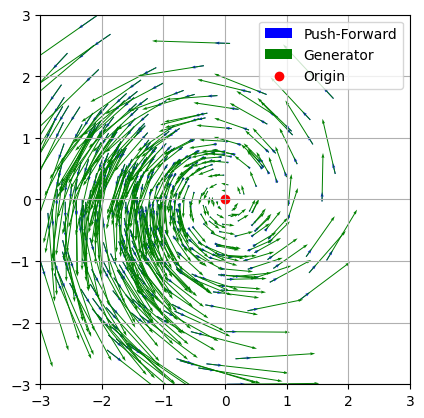

In [440]:
import matplotlib.pyplot as plt
plt.quiver(ps_test_tilde[:,0], ps_test_tilde[:,1], ps_kernel_bases_flat[:,0], ps_kernel_bases_flat[:,1], angles='xy', scale_units='xy', scale=10, color='blue', label="Push-Forward")
plt.quiver(ps_test_tilde[:,0], ps_test_tilde[:,1], ps_generator_flat[:,0], ps_generator_flat[:,1], angles='xy', scale_units='xy', scale=10, color='green', label="Generator")
plt.scatter(0,0, label="Origin", color="red")
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.gca().set_aspect('equal')
plt.legend()
plt.grid()

## Learn the Translation Map F

In [ ]:
# Diffeomorphism, in our case the space of all affine maps.
H_0=th.tensor(th.randn(size=(STATE_DIM+1, STATE_DIM+1)), dtype=DTYPE, requires_grad=True)

def learn_translation_map(H_0:th.tensor,
                         vf_1: callable,
                         vf_2: callable,
                         n_iter:int=20_000,
                         )->th.tensor:
    """
    TODO
    """

    warnings.warn("Tested only for one-dimensional Kernels.")
    pbar = tqdm(range(n_iter), desc="Compute Meta-Symmetry")

    H=th.tensor(H_0.clone(), dtype=DTYPE, requires_grad=True)
    opt_H=th.optim.Adam([H], lr=0.00035)

    for idx_step in pbar:

        # Project log left actions onto the vector space spanned by W.
        # W_perp is the orthogonal complement of each left-action with respect to W
        _, W_perp=project_onto_tensor_subspace(tensors=log_left_actions, basis=W)
        W_perp_flat=W_perp.squeeze(1) #remove the Lie group dimension (always 1). New shape: (N_tasks, N_states, N_states)

        # Compute loss. If G contains all left-actions, the log-left-actions must be inside the span of W.
        # Each orthogonal complement is a tensor of shape (n_state, n_states). Compute the Frobenius norm of each orthogonal complement
        # and mean across all tasks.
        loss = th.mean(th.norm(W_perp_flat, p="fro",dim=(1,2)),dim=0)
        
        # Take gradient step
        opt_H.zero_grad()
        loss.backward()
        opt_H.step()
        if idx_step % 100 == 0:
            pbar.set_postfix({'Meta-Symmetry. Loss (optimum=0)': f'{loss:.2f}'})

    return H.round(decimals=3)